# Notebook de ánalisis de información

In [1]:
# librerias base
import math
import os
import shutil 
import sys

#librerias externas
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp  

# librerias propias
# Carpeta del proyecto
dir_proyecto, _ = os.path.split(os.getcwd())
sys.path.append(dir_proyecto)
from SCRIPTS.funciones import *

In [2]:
df = leer_parquet(os.path.join(dir_proyecto,'INPUTS'))
df.head(2)

,nombre_entidad,nit_entidad,departamento,ciudad,localizaci_n,orden,sector,rama,entidad_centralizada,proceso_de_compra,...,recursos_de_credito,recursos_propios,ultima_actualizacion,codigo_entidad,codigo_proveedor,objeto_del_contrato,fecha_inicio_liquidacion,fecha_fin_liquidacion,fecha_de_inicio_de_ejecucion,fecha_de_fin_de_ejecucion
0,MUNICIPIO DE TUNJA,891800846,Boyacá,Tunja,"Colombia, Boyacá , Tunja",Territorial,Servicio Público,Ejecutivo,Descentralizada,CO1.BDOS.3881955,...,0,0,2023-07-25T00:00:00.000,702354804,705396323,SMA034 RESTAURACIÓN DE LA COBERTURA VEGETAL EN...,None,None,NaN,NaN
1,ALCALDIA DE FLORENCIA CAUCA,800188492,Cauca,Florencia,"Colombia, Cauca , Florencia",Territorial,No aplica/No pertenece,Ejecutivo,Descentralizada,CO1.BDOS.4146649,...,1360000000,0,2023-03-13T00:00:00.000,702224064,704040070,CONTRATO DE EMPRÉSTITO Y PIGNORACIÓN DE RENTAS...,None,None,NaN,NaN


In [3]:
print("\033[1mDimensiones de la data\n\033[0m")

print("Las dimensiones de la data son: " +str(df.shape[0]) +" filas y " + str(df.shape[1])+ " columnas\n")

print("\033[1mTipos de variables\n\033[0m")

print(df.info())

Dimensiones de la data

Las dimensiones de la data son: 39884 filas y 71 columnas

Tipos de variables

<class 'pandas.core.frame.DataFrame'>
Index: 39884 entries, 0 to 4999
Data columns (total 71 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   nombre_entidad                                                    39884 non-null  object
 1   nit_entidad                                                       39884 non-null  object
 2   departamento                                                      39884 non-null  object
 3   ciudad                                                            39884 non-null  object
 4   localizaci_n                                                      39884 non-null  object
 5   orden                                                             39884 non-null  object
 6   sector                               

Se cuenta con información de 39.884 contratos y cada uno con 71 variables descriptivas del mismo. 


Al cargar la data, se observa existen variables con una cantidad significativa de valores nulos, por lo tanto se realiza el siguiente tratamiento: 

### 1. Tratamiento de Valores null

In [4]:
variables_con_nulos = df.isna().sum()

# Filtrar variables con valores perdidos
variables_con_nulos = variables_con_nulos[variables_con_nulos > 0]

for variable, cantidad_nulos in variables_con_nulos.items():
    print(f"{variable}, {cantidad_nulos}")
    
print("\nSe tiene un total de " + str(df.isna().sum().sum()) + " datos pérdidos")

fecha_de_inicio_del_contrato, 3193
documento_proveedor, 1
valor_pendiente_de_ejecucion, 162
ultima_actualizacion, 41
codigo_proveedor, 79
objeto_del_contrato, 72
fecha_inicio_liquidacion, 23719
fecha_fin_liquidacion, 23720
fecha_de_inicio_de_ejecucion, 39878
fecha_de_fin_de_ejecucion, 39878

Se tiene un total de 130743 datos pérdidos


Teniendo en cuenta se tiene un total de 130.743 valores nulos, se realizará el siguiente tratamiento:
    
1. Se procederá a eliminar las variables relacionadas con fechas. Esto debido a que, además de tener una gran cantidad de valores nulos, consideramos que no tendrán un impacto significativo en el modelo propuesto para el estudio.
    
2. Así mismo se eliminaran las filas de las demás variables que representan menos del 1%.

In [5]:
df = df.drop(['fecha_inicio_liquidacion','fecha_fin_liquidacion','fecha_de_inicio_de_ejecucion','fecha_de_fin_de_ejecucion','fecha_de_inicio_del_contrato'], axis=1)
df = df.dropna()

### 2. Selección inicial de variables.

Después de una exhaustiva revisión del diccionario de datos disponibles en el conjunto de contratos electrónicos del SECOP II, que puede ser consultado en el enlace: https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Contratos-Electr-nicos/jbjy-vk9h, hemos determinado que algunas variables no serán consideradas en nuestro modelo de estudio debido a su falta de relevancia. Las variables que excluiremos son las siguientes: 

* 'Localización' y 'ciudad' son lo mismo por lo tanto dejamos ciudad. 
* Información detallada del proveedor elegido no será tomada en cuenta en nuestro análisis, ya que el princial objetivo es generar una clasificación por sectores que permita a los proveedores presentar sus postulaciones.
* También excluiremos identificadores únicos dentro de cada contrato, como 'id_contrato', 'referencia_del_contrato', entre otros ya que no aportan información significativa para la clasificación. 

In [6]:
df_final = df.drop(['localizaci_n','proceso_de_compra', 'id_contrato', 'referencia_del_contrato',
                    'justificacion_modalidad_de','tipodocproveedor', 'documento_proveedor', 'proveedor_adjudicado',
                    'es_grupo', 'es_pyme','estado_bpin', 'c_digo_bpin', 'anno_bpin','espostconflicto', 'urlproceso',
                    'dias_adicionados','nombre_representante_legal','nacionalidad_representante_legal',
                    'tipo_de_identificaci_n_representante_legal','identificaci_n_representante_legal', 
                    'g_nero_representante_legal','ultima_actualizacion','codigo_entidad', 'codigo_proveedor',
                    'fecha_de_firma', 'fecha_de_fin_del_contrato'], axis=1)

In [7]:
df_final.shape

(39529, 40)

Se contará con 40 variables para ánalisis descriptivo. 

### 3. Tipos de variables:

Se realizó el cambio de tipo de variables, teniendo en cuenta que esta considerando todas de tipo object, como se muestra a continuación: 

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39529 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   nombre_entidad                                                    39529 non-null  object
 1   nit_entidad                                                       39529 non-null  object
 2   departamento                                                      39529 non-null  object
 3   ciudad                                                            39529 non-null  object
 4   orden                                                             39529 non-null  object
 5   sector                                                            39529 non-null  object
 6   rama                                                              39529 non-null  object
 7   entidad_centralizada                          

In [9]:
df_final


,nombre_entidad,nit_entidad,departamento,ciudad,orden,sector,rama,entidad_centralizada,estado_contrato,codigo_de_categoria_principal,...,origen_de_los_recursos,puntos_del_acuerdo,pilares_del_acuerdo,presupuesto_general_de_la_nacion_pgn,sistema_general_de_participaciones,sistema_general_de_regal_as,recursos_propios_alcald_as_gobernaciones_y_resguardos_ind_genas_,recursos_de_credito,recursos_propios,objeto_del_contrato
0,MUNICIPIO DE TUNJA,891800846,Boyacá,Tunja,Territorial,Servicio Público,Ejecutivo,Descentralizada,Modificado,V1.10152000,...,Distribuido,No aplica,No aplica,0,0,346033644,69861393,0,0,SMA034 RESTAURACIÓN DE LA COBERTURA VEGETAL EN...
1,ALCALDIA DE FLORENCIA CAUCA,800188492,Cauca,Florencia,Territorial,No aplica/No pertenece,Ejecutivo,Descentralizada,Activo,V1.84121500,...,Distribuido,No aplica,No aplica,0,0,0,0,1360000000,0,CONTRATO DE EMPRÉSTITO Y PIGNORACIÓN DE RENTAS...
2,AGENCIA LOGISTICA DE LAS FUERZAS MILITARES,899999162,Distrito Capital de Bogotá,Bogotá,Nacional,defensa,Ejecutivo,Descentralizada,En ejecución,V1.50111500,...,Distribuido,No aplica,No aplica,324330000,0,0,0,0,0,SUMINISTRO DE CARNE DE RES Y CERDO SIN ADITIVO...
3,INSTITUTO DE VALORIZACION DE MANIZALES,800002916,Caldas,Manizales,Territorial,Minas y Energía,Ejecutivo,Descentralizada,En ejecución,V1.92121504,...,Distribuido,No aplica,No aplica,0,0,0,110800000,0,0,PRESTAR EL SERVICIO DE VIGILANCIA Y SEGURIDAD ...
4,HMI,802013023,Atlántico,Soledad,Territorial,Salud y Protección Social,Corporación Autónoma,Descentralizada,En ejecución,V1.82101600,...,Distribuido,No aplica,No aplica,0,0,0,105000000,0,0,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA DEF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,UNIDADES TECNOLOGICAS DE SANTANDER,890208727,Santander,Bucaramanga,Territorial,No aplica/No pertenece,Corporación Autónoma,Descentralizada,En ejecución,V1.81111805,...,Recursos Propios,No aplica,No aplica,0,0,0,0,0,183624120,CONTRATACIÓN DE SERVICIOS PROFESIONALES ESPECI...
4996,EMPRESA DE ENERGÍA DE CASANARE SA ESP,844004576,Casanare,Yopal,Territorial,Minas y Energía,Corporación Autónoma,Descentralizada,terminado,V1.20102301,...,Distribuido,No aplica,No aplica,0,0,0,203411992,0,0,SERVICIO DE TRANSPORTE TERRESTRE DE PERSONAL I...
4997,ICBF REGIONAL CAUCA,899999239,Cauca,Popayán,Nacional,Salud y Protección Social,Ejecutivo,Centralizada,Modificado,V1.93141500,...,Distribuido,No aplica,No aplica,723092015,0,0,0,0,0,PRESTAR LOS SERVICIOS DE EDUCACIÓN INICIAL EN ...
4998,MUNICIPIO DE MONTERIA,800096734,Córdoba,Montería,Territorial,Servicio Público,Ejecutivo,Descentralizada,En ejecución,V1.80111600,...,Distribuido,No aplica,No aplica,0,0,0,128955147,0,0,PRESTACIÓN DE SERVICIOS PROFESIONALES Y ESPECI...


In [10]:

df_final['liquidaci_n'] = df['liquidaci_n'].apply(lambda x: 1 if x== "Si" else 0)
df_final['habilita_pago_adelantado'] = df['habilita_pago_adelantado'].apply(lambda x: 1 if x== "Si" else 0)

In [11]:
# Variables continuas: 

Variables_num = [
    'valor_del_contrato',
    'valor_de_pago_adelantado',
    'valor_facturado',
    'valor_pendiente_de_pago',
    'valor_pagado',
    'valor_amortizado',
    'valor_pendiente_de',
    'valor_pendiente_de_ejecucion',
    'saldo_cdp',
    'saldo_vigencia','presupuesto_general_de_la_nacion_pgn','recursos_de_credito','recursos_propios',
    'sistema_general_de_regal_as','recursos_propios_alcald_as_gobernaciones_y_resguardos_ind_genas_']
for i in Variables_num:
    df_final[i] = df_final[i].astype(int)

### 4. Ánalisis descriptivo de variables continuas

In [27]:
def calcular_estadisticas(df:pd.DataFrame)->pd.DataFrame:
    estadisticas = pd.DataFrame((df.describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
    estadisticas = estadisticas.T
    estadisticas['range'] = estadisticas['max']- estadisticas['min']
    estadisticas['median'] = [np.median(df.loc[:,i]) for i in estadisticas.index]
    estadisticas['skew'] = [sp.skew(df.loc[:,i]) for i in estadisticas.index]
    estadisticas['kurtosis'] = [sp.kurtosis(df.loc[:,i]) for i in estadisticas.index]
    estadisticas = estadisticas[['count', 'mean', 'median', 'std', 'min','50%', '60%', '90%', 'max']].round(2)
    return estadisticas



print("\n**Estadísticas de resumen de las variables continuas\n")
display(calcular_estadisticas(df_final[Variables_num]))


**Estadísticas de resumen de las variables continuas



,count,mean,median,std,min,50%,60%,90%,max
valor_del_contrato,39529.0,9.730076e+09,259500000.0,9.885728e+11,100000000.0,259500000.0,371512900.8,2.337570e+09,1.420769e+14
valor_de_pago_adelantado,39529.0,5.254390e+06,0.0,3.958526e+08,0.0,0.0,0.0,0.000000e+00,7.211400e+10
valor_facturado,39529.0,1.455322e+08,0.0,2.328566e+09,0.0,0.0,0.0,1.764450e+08,3.012965e+11
valor_pendiente_de_pago,39529.0,1.332936e+09,233283000.0,1.020819e+10,0.0,233283000.0,332716496.4,2.175757e+09,8.612227e+11
valor_pagado,39529.0,8.614789e+07,0.0,1.641678e+09,0.0,0.0,0.0,8.424767e+07,2.941453e+11
valor_amortizado,39529.0,8.262310e+04,0.0,4.175703e+06,0.0,0.0,0.0,0.000000e+00,4.507895e+08
valor_pendiente_de,39529.0,5.171767e+06,0.0,3.958302e+08,0.0,0.0,0.0,0.000000e+00,7.211400e+10
valor_pendiente_de_ejecucion,39529.0,1.332061e+09,233178688.0,1.020750e+10,-14.0,233178688.0,332581312.2,2.175757e+09,8.612227e+11
saldo_cdp,39529.0,4.724623e+09,288000000.0,9.516137e+10,0.0,288000000.0,445032416.0,4.461170e+09,1.539000e+13
saldo_vigencia,39529.0,5.349507e+08,0.0,1.478360e+10,0.0,0.0,0.0,0.000000e+00,1.140539e+12


In [15]:
df_final

,nombre_entidad,nit_entidad,departamento,ciudad,orden,sector,rama,entidad_centralizada,estado_contrato,codigo_de_categoria_principal,...,origen_de_los_recursos,puntos_del_acuerdo,pilares_del_acuerdo,presupuesto_general_de_la_nacion_pgn,sistema_general_de_participaciones,sistema_general_de_regal_as,recursos_propios_alcald_as_gobernaciones_y_resguardos_ind_genas_,recursos_de_credito,recursos_propios,objeto_del_contrato
0,MUNICIPIO DE TUNJA,891800846,Boyacá,Tunja,Territorial,Servicio Público,Ejecutivo,Descentralizada,Modificado,V1.10152000,...,Distribuido,No aplica,No aplica,0,0,346033644,69861393,0,0,SMA034 RESTAURACIÓN DE LA COBERTURA VEGETAL EN...
1,ALCALDIA DE FLORENCIA CAUCA,800188492,Cauca,Florencia,Territorial,No aplica/No pertenece,Ejecutivo,Descentralizada,Activo,V1.84121500,...,Distribuido,No aplica,No aplica,0,0,0,0,1360000000,0,CONTRATO DE EMPRÉSTITO Y PIGNORACIÓN DE RENTAS...
2,AGENCIA LOGISTICA DE LAS FUERZAS MILITARES,899999162,Distrito Capital de Bogotá,Bogotá,Nacional,defensa,Ejecutivo,Descentralizada,En ejecución,V1.50111500,...,Distribuido,No aplica,No aplica,324330000,0,0,0,0,0,SUMINISTRO DE CARNE DE RES Y CERDO SIN ADITIVO...
3,INSTITUTO DE VALORIZACION DE MANIZALES,800002916,Caldas,Manizales,Territorial,Minas y Energía,Ejecutivo,Descentralizada,En ejecución,V1.92121504,...,Distribuido,No aplica,No aplica,0,0,0,110800000,0,0,PRESTAR EL SERVICIO DE VIGILANCIA Y SEGURIDAD ...
4,HMI,802013023,Atlántico,Soledad,Territorial,Salud y Protección Social,Corporación Autónoma,Descentralizada,En ejecución,V1.82101600,...,Distribuido,No aplica,No aplica,0,0,0,105000000,0,0,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA DEF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,UNIDADES TECNOLOGICAS DE SANTANDER,890208727,Santander,Bucaramanga,Territorial,No aplica/No pertenece,Corporación Autónoma,Descentralizada,En ejecución,V1.81111805,...,Recursos Propios,No aplica,No aplica,0,0,0,0,0,183624120,CONTRATACIÓN DE SERVICIOS PROFESIONALES ESPECI...
4996,EMPRESA DE ENERGÍA DE CASANARE SA ESP,844004576,Casanare,Yopal,Territorial,Minas y Energía,Corporación Autónoma,Descentralizada,terminado,V1.20102301,...,Distribuido,No aplica,No aplica,0,0,0,203411992,0,0,SERVICIO DE TRANSPORTE TERRESTRE DE PERSONAL I...
4997,ICBF REGIONAL CAUCA,899999239,Cauca,Popayán,Nacional,Salud y Protección Social,Ejecutivo,Centralizada,Modificado,V1.93141500,...,Distribuido,No aplica,No aplica,723092015,0,0,0,0,0,PRESTAR LOS SERVICIOS DE EDUCACIÓN INICIAL EN ...
4998,MUNICIPIO DE MONTERIA,800096734,Córdoba,Montería,Territorial,Servicio Público,Ejecutivo,Descentralizada,En ejecución,V1.80111600,...,Distribuido,No aplica,No aplica,0,0,0,128955147,0,0,PRESTACIÓN DE SERVICIOS PROFESIONALES Y ESPECI...


# Análisis de variables

In [16]:
df = df_final.iloc[:,:-1]

In [17]:
df.head(3)

,nombre_entidad,nit_entidad,departamento,ciudad,orden,sector,rama,entidad_centralizada,estado_contrato,codigo_de_categoria_principal,...,destino_gasto,origen_de_los_recursos,puntos_del_acuerdo,pilares_del_acuerdo,presupuesto_general_de_la_nacion_pgn,sistema_general_de_participaciones,sistema_general_de_regal_as,recursos_propios_alcald_as_gobernaciones_y_resguardos_ind_genas_,recursos_de_credito,recursos_propios
0,MUNICIPIO DE TUNJA,891800846,Boyacá,Tunja,Territorial,Servicio Público,Ejecutivo,Descentralizada,Modificado,V1.10152000,...,Inversión,Distribuido,No aplica,No aplica,0,0,346033644,69861393,0,0
1,ALCALDIA DE FLORENCIA CAUCA,800188492,Cauca,Florencia,Territorial,No aplica/No pertenece,Ejecutivo,Descentralizada,Activo,V1.84121500,...,Funcionamiento,Distribuido,No aplica,No aplica,0,0,0,0,1360000000,0
2,AGENCIA LOGISTICA DE LAS FUERZAS MILITARES,899999162,Distrito Capital de Bogotá,Bogotá,Nacional,defensa,Ejecutivo,Descentralizada,En ejecución,V1.50111500,...,Funcionamiento,Distribuido,No aplica,No aplica,324330000,0,0,0,0,0


In [18]:
df['orden'].unique()

array(['Territorial', 'Nacional', 'Corporación Autónoma'], dtype=object)

In [19]:
df['destino_gasto'].unique()

array(['Inversión', 'Funcionamiento', 'No Definido'], dtype=object)

In [20]:
df['origen_de_los_recursos'].unique()

array(['Distribuido', 'Recursos Propios'], dtype=object)

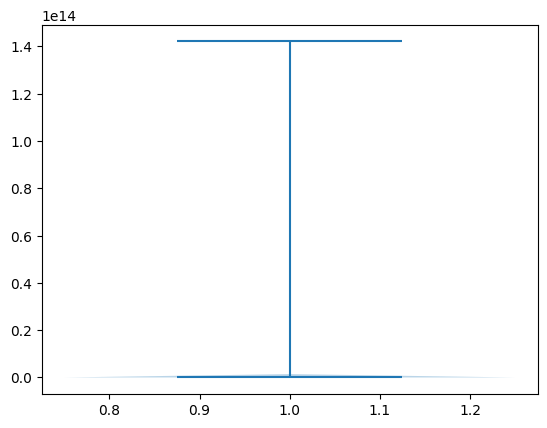

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.violinplot(df['valor_del_contrato'])
plt.show()

<Axes: xlabel='valor_del_contrato', ylabel='Density'>

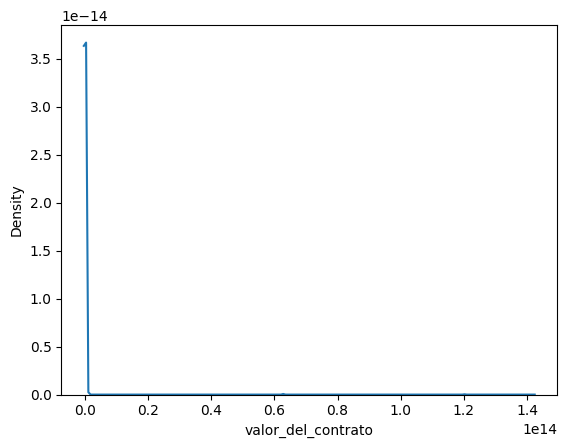

In [22]:
# Gráfico de densidad
sns.kdeplot(df['valor_del_contrato'])

In [23]:
valor = df['valor_del_contrato'].sort_values(ascending = False)

In [26]:
valor.iloc[0:60]

108     142076864160000
4623    120357947983729
50       62879190529600
1737      1140538892678
4562      1100930132000
883       1004321513847
4331       861222696024
2937       695963258379
1392       499589297791
3963       492685537489
1378       477834784322
3275       430050000000
3085       358283324633
509        344883020784
4373       341838822928
716        330000000000
4972       310820231159
826        300000000000
229        299757710085
3980       294145282376
2988       244959800681
3429       240380000000
3407       231944342239
1372       225663498495
631        216674584973
2684       210228406065
678        198802459764
1036       190679663049
1034       186881916144
2212       150000000000
1526       148800000000
245        143941663113
2787       143750000000
3635       136500000000
2809       135000000000
1581       128480000036
2968       128199063261
865        120998333065
3488       114635217384
4040       111055782000
821        110739885828
3761       11000

# Variables categóricas

In [30]:
columnas_categoricas = df_final.select_dtypes(include=['object'])
columnas_categoricas

,nombre_entidad,nit_entidad,departamento,ciudad,orden,sector,rama,entidad_centralizada,estado_contrato,codigo_de_categoria_principal,...,condiciones_de_entrega,obligaci_n_ambiental,obligaciones_postconsumo,reversion,destino_gasto,origen_de_los_recursos,puntos_del_acuerdo,pilares_del_acuerdo,sistema_general_de_participaciones,objeto_del_contrato
0,MUNICIPIO DE TUNJA,891800846,Boyacá,Tunja,Territorial,Servicio Público,Ejecutivo,Descentralizada,Modificado,V1.10152000,...,A convenir,No,No,No,Inversión,Distribuido,No aplica,No aplica,0,SMA034 RESTAURACIÓN DE LA COBERTURA VEGETAL EN...
1,ALCALDIA DE FLORENCIA CAUCA,800188492,Cauca,Florencia,Territorial,No aplica/No pertenece,Ejecutivo,Descentralizada,Activo,V1.84121500,...,A convenir,No,No,No,Funcionamiento,Distribuido,No aplica,No aplica,0,CONTRATO DE EMPRÉSTITO Y PIGNORACIÓN DE RENTAS...
2,AGENCIA LOGISTICA DE LAS FUERZAS MILITARES,899999162,Distrito Capital de Bogotá,Bogotá,Nacional,defensa,Ejecutivo,Descentralizada,En ejecución,V1.50111500,...,Como acordado previamente,No,No,No,Funcionamiento,Distribuido,No aplica,No aplica,0,SUMINISTRO DE CARNE DE RES Y CERDO SIN ADITIVO...
3,INSTITUTO DE VALORIZACION DE MANIZALES,800002916,Caldas,Manizales,Territorial,Minas y Energía,Ejecutivo,Descentralizada,En ejecución,V1.92121504,...,A convenir,No,No,No,Funcionamiento,Distribuido,No aplica,No aplica,0,PRESTAR EL SERVICIO DE VIGILANCIA Y SEGURIDAD ...
4,HMI,802013023,Atlántico,Soledad,Territorial,Salud y Protección Social,Corporación Autónoma,Descentralizada,En ejecución,V1.82101600,...,A convenir,No,No,No,Funcionamiento,Distribuido,No aplica,No aplica,0,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA DEF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,UNIDADES TECNOLOGICAS DE SANTANDER,890208727,Santander,Bucaramanga,Territorial,No aplica/No pertenece,Corporación Autónoma,Descentralizada,En ejecución,V1.81111805,...,Como acordado previamente,No,No,No,Funcionamiento,Recursos Propios,No aplica,No aplica,0,CONTRATACIÓN DE SERVICIOS PROFESIONALES ESPECI...
4996,EMPRESA DE ENERGÍA DE CASANARE SA ESP,844004576,Casanare,Yopal,Territorial,Minas y Energía,Corporación Autónoma,Descentralizada,terminado,V1.20102301,...,A convenir,No,No,No,Funcionamiento,Distribuido,No aplica,No aplica,0,SERVICIO DE TRANSPORTE TERRESTRE DE PERSONAL I...
4997,ICBF REGIONAL CAUCA,899999239,Cauca,Popayán,Nacional,Salud y Protección Social,Ejecutivo,Centralizada,Modificado,V1.93141500,...,Como acordado previamente,No,No,No,Inversión,Distribuido,No aplica,No aplica,0,PRESTAR LOS SERVICIOS DE EDUCACIÓN INICIAL EN ...
4998,MUNICIPIO DE MONTERIA,800096734,Córdoba,Montería,Territorial,Servicio Público,Ejecutivo,Descentralizada,En ejecución,V1.80111600,...,A convenir,No,No,No,Inversión,Distribuido,No aplica,No aplica,0,PRESTACIÓN DE SERVICIOS PROFESIONALES Y ESPECI...


In [34]:
columnas_categoricas.columns

Index(['nombre_entidad', 'nit_entidad', 'departamento', 'ciudad', 'orden',
       'sector', 'rama', 'entidad_centralizada', 'estado_contrato',
       'codigo_de_categoria_principal', 'descripcion_del_proceso',
       'tipo_de_contrato', 'modalidad_de_contratacion',
       'condiciones_de_entrega', 'obligaci_n_ambiental',
       'obligaciones_postconsumo', 'reversion', 'destino_gasto',
       'origen_de_los_recursos', 'puntos_del_acuerdo', 'pilares_del_acuerdo',
       'sistema_general_de_participaciones', 'objeto_del_contrato'],
      dtype='object')

In [36]:
columnas_categoricas['sector'].unique()

array(['Servicio Público', 'No aplica/No pertenece', 'defensa',
       'Minas y Energía', 'Salud y Protección Social', 'agricultura',
       'Transporte', 'Vivienda, Ciudad y Territorio', 'Cultura',
       'Educación Nacional', 'Ambiente y Desarrollo Sostenible',
       'Hacienda y Crédito Público', 'Industria', 'Ley de Justicia',
       'interior', 'Presidencia de la República', 'deportes', 'Trabajo',
       'Tecnologías de la Información y las Comunicaciones', 'Planeación',
       'Inclusión Social y Reconciliación', 'Relaciones Exteriores',
       'Ciencia Tecnología', 'Información Estadística',
       'Inteligencia Estratégica y Contrainteligencia'], dtype=object)

In [50]:
sector = columnas_categoricas.groupby(by=['sector']).count()
#sector_ordenado = sector.sort_values(ascending=False)
sector

,nombre_entidad,nit_entidad,departamento,ciudad,orden,rama,entidad_centralizada,estado_contrato,codigo_de_categoria_principal,descripcion_del_proceso,...,condiciones_de_entrega,obligaci_n_ambiental,obligaciones_postconsumo,reversion,destino_gasto,origen_de_los_recursos,puntos_del_acuerdo,pilares_del_acuerdo,sistema_general_de_participaciones,objeto_del_contrato
sector,,,,,,,,,,,,,,,,,,,,,
Ambiente y Desarrollo Sostenible,1786,1786,1786,1786,1786,1786,1786,1786,1786,1786,...,1786,1786,1786,1786,1786,1786,1786,1786,1786,1786
Ciencia Tecnología,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
Cultura,880,880,880,880,880,880,880,880,880,880,...,880,880,880,880,880,880,880,880,880,880
Educación Nacional,1783,1783,1783,1783,1783,1783,1783,1783,1783,1783,...,1783,1783,1783,1783,1783,1783,1783,1783,1783,1783
Hacienda y Crédito Público,440,440,440,440,440,440,440,440,440,440,...,440,440,440,440,440,440,440,440,440,440
Inclusión Social y Reconciliación,827,827,827,827,827,827,827,827,827,827,...,827,827,827,827,827,827,827,827,827,827
Industria,494,494,494,494,494,494,494,494,494,494,...,494,494,494,494,494,494,494,494,494,494
Información Estadística,62,62,62,62,62,62,62,62,62,62,...,62,62,62,62,62,62,62,62,62,62
Inteligencia Estratégica y Contrainteligencia,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [42]:
columnas_categoricas['sector'].unique()

array(['Servicio Público', 'No aplica/No pertenece', 'defensa',
       'Minas y Energía', 'Salud y Protección Social', 'agricultura',
       'Transporte', 'Vivienda, Ciudad y Territorio', 'Cultura',
       'Educación Nacional', 'Ambiente y Desarrollo Sostenible',
       'Hacienda y Crédito Público', 'Industria', 'Ley de Justicia',
       'interior', 'Presidencia de la República', 'deportes', 'Trabajo',
       'Tecnologías de la Información y las Comunicaciones', 'Planeación',
       'Inclusión Social y Reconciliación', 'Relaciones Exteriores',
       'Ciencia Tecnología', 'Información Estadística',
       'Inteligencia Estratégica y Contrainteligencia'], dtype=object)

In [51]:
import session_info

session_info.show(html=False)

-----
SCRIPTS             NA
matplotlib          3.7.2
numpy               1.24.3
pandas              2.0.3
scipy               1.10.1
seaborn             0.12.2
session_info        1.0.0
sodapy              2.2.0
-----
IPython             8.12.0
jupyter_client      8.1.0
jupyter_core        5.3.0
jupyterlab          3.6.3
notebook            6.5.4
-----
Python 3.11.3 (main, Apr 19 2023, 18:51:09) [Clang 14.0.6 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2023-09-04 19:03
